In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from collections import Counter

In [19]:
df_scaled = pd.read_csv('final-preprocessed-updated.csv')

In [ ]:
# PHASE 1: TARGET DEFINITION & LEAKAGE CONTROL
# Defining pillars used in target calculation (The "Cheat Codes")
leaky_pillars = ['pl_rade', 'pl_insol', 'pl_eqt', 'pl_orbeccen']
# Identifiers and non-numeric strings
identifiers = ['pl_name', 'hostname', 'st_spectype', 'discoverymethod']

X = df_scaled.drop(columns=leaky_pillars + identifiers + ['habitability_score'])
y = df_scaled['habitability_score']

# Create a stratified mask: 1 if score > 0.7 (Gems), else 0
# This ensures rare planets are represented in both Train and Test sets
y_stratify_mask = (y > 0.7).astype(int)

In [ ]:
# PHASE 2: STRATIFIED TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_stratify_mask
)

print(f"Total planets in Training: {len(X_train)}")
print(f"Total planets in Testing: {len(X_test)}")
print(f"Gems in Training: {(y_train > 0.7).sum()} | Gems in Testing: {(y_test > 0.7).sum()}")

Total planets in Training: 4355
Total planets in Testing: 1089
Gems in Training: 25 | Gems in Testing: 6


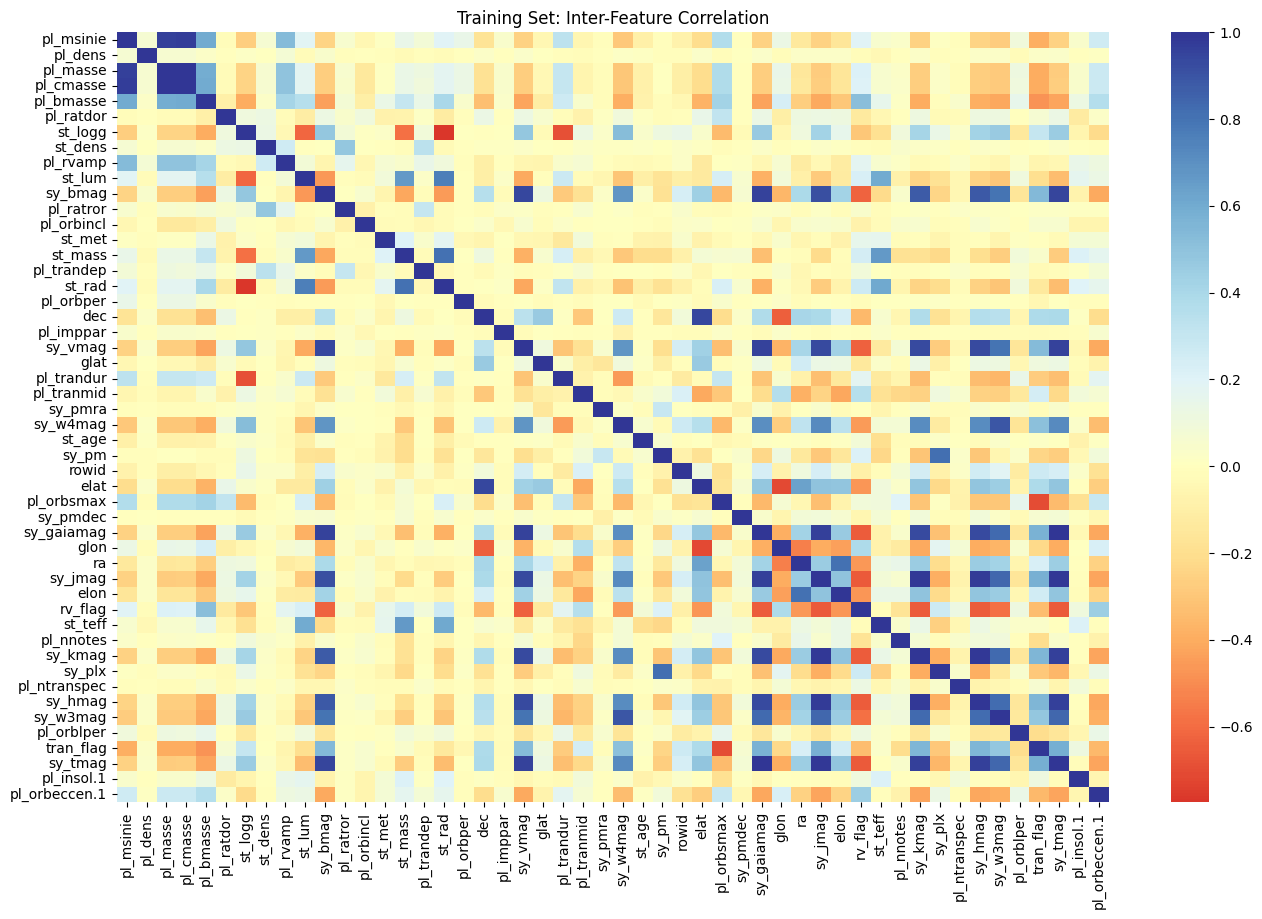


Highly correlated features detected: ['pl_masse', 'pl_cmasse', 'sy_vmag', 'elat', 'sy_gaiamag', 'sy_jmag', 'sy_kmag', 'sy_hmag', 'sy_w3mag', 'sy_tmag']

Top 10 VIF Results (Before Pruning):
        feature         VIF
3    pl_cmasse  147.684428
2     pl_masse  133.738677
47     sy_tmag  133.020725
35     sy_jmag  105.548346
40     sy_kmag   59.477937
32  sy_gaiamag   54.225844
43     sy_hmag   46.405009
29        elat   42.416063
18         dec   30.619883
20     sy_vmag   29.160843
Pruning complete. New feature count: 39


In [ ]:
# PHASE 3: CORRELATION & MULTICOLLINEARITY (VIF)
# 3.1. Correlation Analysis
plt.figure(figsize=(16, 10))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap='RdYlBu', center=0)
plt.title("Training Set: Inter-Feature Correlation")
plt.show()

# Identify features with correlation > 0.85
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.85)]
print(f"\nHighly correlated features detected: {to_drop_corr}")

# 3.2. VIF Analysis (Variance Inflation Factor)
def calculate_vif(df_vif):
    vif_df = pd.DataFrame()
    vif_df["feature"] = df_vif.columns
    vif_df["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]
    return vif_df.sort_values(by="VIF", ascending=False)

# Check VIF to remove hidden redundancies
vif_results = calculate_vif(X_train)
print("\nTop 10 VIF Results (Before Pruning):\n", vif_results.head(10))

# Automated Pruning: Dropping redundant columns (Mass and Mag clusters)
features_to_prune = list(set(to_drop_corr + ['pl_cmasse', 'pl_msinie', 'sy_gaiamag', 'sy_w1mag']))
X_train_pruned = X_train.drop(columns=[f for f in features_to_prune if f in X_train.columns])
X_test_pruned = X_test.drop(columns=[f for f in features_to_prune if f in X_test.columns])

print(f"Pruning complete. New feature count: {X_train_pruned.shape[1]}")

In [ ]:
# PHASE 4: SYNTHETIC DATA GENERATION (SMOTE)
# We use SMOTE to balance the representation of high-habitability zones
# This helps the model 'see' the characteristics of habitable worlds more clearly
y_train_bin = (y_train > 0.7).astype(int)

sm = SMOTE(random_state=42)
X_train_res, y_train_res_bin = sm.fit_resample(X_train_pruned, y_train_bin)

print(f"\nResampled Training Distribution: {Counter(y_train_res_bin)}")


Resampled Training Distribution: Counter({0: 4330, 1: 4330})


In [ ]:
# PHASE 5: EXPORT FOR MODELING
# Exporting Final Data
X_train_res.to_csv('X_train_final.csv', index=False)
y_train_res_bin.to_csv('y_train_final.csv', index=False) # For Classification tasks
y_train.to_csv('y_train_regression.csv', index=False)  # For Regression tasks

X_test_pruned.to_csv('X_test_final.csv', index=False)
y_test.to_csv('y_test_final.csv', index=False)


Milestone 3 Officially Completed. Data is clean, balanced, and ready for modeling.
